# Processing IMDB 

In [4]:
import os
imdb_dir = './data/aclImdb'
train_dir = os.path.join(imdb_dir,'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [56]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 20000
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [57]:
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')

Found 88582 unique tokens


In [58]:
data = pad_sequences(sequences, maxlen=maxlen)

In [59]:
labels = np.asarray(labels)

In [60]:
data.shape, labels.shape

((25000, 100), (25000,))

In [61]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data=data[indices]
labels=labels[indices]

X_train = data[:training_samples]
y_train = labels[:training_samples]
X_val = data[training_samples:]
y_val = labels[training_samples:]

In [13]:
#Use pyspark to process word_embedding
import pyspark as ps
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('lecture')
         .getOrCreate()
        )
sc = spark.sparkContext

In [14]:
df = spark.read.csv('data/glove.6B/glove.6B.50d.txt',
                   header=False,             # char for quotes
                         sep=" ",           # char for separation
                         inferSchema=True)

Dense	 Embedding	 Flatten	 Sequential	 Tokenizer	 X_test	 X_train	 X_val	 character	 
characters	 data	 df	 dimensionality	 dir_name	 f	 fname	 history	 i	 
imdb	 imdb_dir	 index	 indices	 j	 label_type	 labels	 max_features	 max_length	 
max_words	 maxlen	 model	 np	 one_hot_results	 pad_sequences	 preprocessing	 ps	 result	 
results	 sample	 samples	 sequences	 string	 texts	 token_index	 tokenizer	 train_dir	 
training_samples	 validation_samples	 word	 word_index	 y_test	 y_train	 y_val	 


In [15]:
glove = np.array(df.select('*').collect())

In [17]:
embeddings_index = {}

for row in glove:
    embeddings_index[row[0]] = row[1:]

In [20]:
embedding_dim = 50

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [43]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                160032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 660,065
Trainable params: 660,065
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [45]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [62]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=[X_val, y_val])
model.save_weights('./data/pre_trained_glove_model.h5')

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 65us/step - loss: 0.7017 - acc: 0.5003 - val_loss: 0.6929 - val_acc: 0.5090
Epoch 2/10
20000/20000 [==============================] - 1s 62us/step - loss: 0.6920 - acc: 0.5095 - val_loss: 0.7034 - val_acc: 0.4990
Epoch 3/10
20000/20000 [==============================] - 1s 63us/step - loss: 0.6850 - acc: 0.5254 - val_loss: 0.7097 - val_acc: 0.5020
Epoch 4/10
20000/20000 [==============================] - 1s 63us/step - loss: 0.6669 - acc: 0.5553 - val_loss: 0.7246 - val_acc: 0.5082
Epoch 5/10
20000/20000 [==============================] - 1s 71us/step - loss: 0.6289 - acc: 0.5980 - val_loss: 0.7373 - val_acc: 0.5112
Epoch 6/10
20000/20000 [==============================] - 1s 66us/step - loss: 0.5791 - acc: 0.6420 - val_loss: 0.8180 - val_acc: 0.5052
Epoch 7/10
20000/20000 [==============================] - 1s 64us/step - loss: 0.5140 - acc: 0.6935 - val_loss: 0.9466 - val_acc:

In [63]:
import matplotlib.pyplot as plt 

In [64]:
def plot_train_val_loss(history_dict, ax):
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values)+1)
    ax.plot(epochs, loss_values,  'bo', label='Training Loss')
    ax.plot(epochs, val_loss_values, 'b', label='Validation Loss')
    ax.set_title('Training and Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    
def plot_train_val_metric(history_dict, ax, metric='accuracy'):
    acc_values = history_dict[metric]
    val_acc_values = history_dict[f'val_{metric}']
    epochs = list(range(1, len(acc_values)+1))
    ax.plot(epochs, acc_values, 'bo', label=f'Training {metric}')
    ax.plot(epochs, val_acc_values, 'b', label=f'Validation {metric}')
    ax.set_title(f'Training and Validation {metric}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(f'{metric}')
    ax.legend()

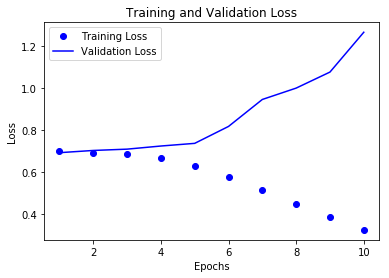

In [65]:
fig, ax = plt.subplots()
plot_train_val_loss(history.history, ax)

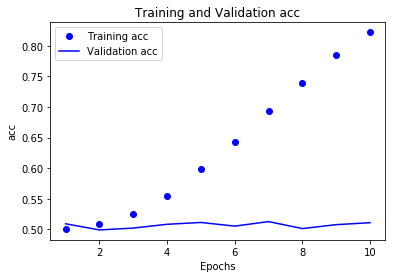

In [66]:
fig, ax = plt.subplots()
plot_train_val_metric(history.history, ax, 'acc')

In [67]:
# training model without pretrained word embeddings

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                160032    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 660,065
Trainable params: 660,065
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [69]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=[X_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 117us/step - loss: 0.6937 - acc: 0.4957 - val_loss: 0.6940 - val_acc: 0.4826
Epoch 2/10
20000/20000 [==============================] - 2s 104us/step - loss: 0.5411 - acc: 0.7384 - val_loss: 0.8323 - val_acc: 0.4992
Epoch 3/10
20000/20000 [==============================] - 2s 108us/step - loss: 0.1759 - acc: 0.9395 - val_loss: 1.2909 - val_acc: 0.4976
Epoch 4/10
20000/20000 [==============================] - 2s 107us/step - loss: 0.0361 - acc: 0.9924 - val_loss: 1.7707 - val_acc: 0.5068
Epoch 5/10
20000/20000 [==============================] - 2s 108us/step - loss: 0.0173 - acc: 0.9968 - val_loss: 1.9276 - val_acc: 0.5124
Epoch 6/10
20000/20000 [==============================] - 2s 110us/step - loss: 0.0103 - acc: 0.9971 - val_loss: 2.4024 - val_acc: 0.5076
Epoch 7/10
20000/20000 [==============================] - 2s 112us/step - loss: 0.0081 - acc: 0.9973 - val_loss: 2.5503 - v

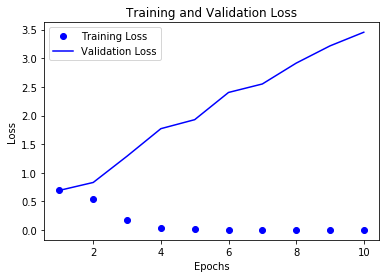

In [70]:
fig,ax = plt.subplots()
plot_train_val_loss(history.history, ax)

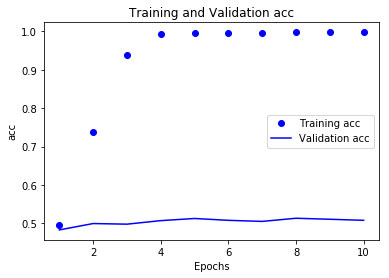

In [71]:
fig, ax = plt.subplots()
plot_train_val_metric(history.history, ax, 'acc')